
# This script loads and prepares data for the equity calculation


In [4]:
#!{sys.executable} -m pip install geopandas
#!conda install --yes --prefix {sys.prefix} geopandas
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
#from IAM_region_mapping import mappingDict
import json

In [3]:
## Parameters

# The gas we want to extract from the historical data

# gas = 'CO2'
gas = 'Kyoto Gases'

# Choose years for analysis

beginning_historical_data = 1850
beginning_pop_hist_data = 1960
end_historical_data = 2015
beginning_modelled_data = 2020
end_modelled_data = 2100
time_laps_model = 10
year_for_equity_calculation1 = 2050
year_for_equity_calculation2 = 2100

date_cumulative_beginning = 1990  # note that this should be after 1960 (the start of the population data)



# Group that are in the extracted historical data, but that are not countries

non_countries = ['ANNEXI', 'NONANNEXI', 'AOSIS', 'BASIC', 'EU28', 'LDC', 'UMBRELLA', 'EARTH']



#Variables of interest

var_image={'Emissions|CO2': 'Total_CO2',
           'Emissions|CO2|Carbon Capture and Storage|Biomass': 'BECCS',
           'Emissions|CO2|Land Use|Carbon Sequestration': 'LANDCDR',
           'Emissions|Kyoto Gases': 'Total_GHG'}
var_remind={'Emissions|CO2': 'Total_CO2',
            'Emissions|CO2|Carbon Capture and Storage|Biomass': 'BECCS',
            'Emissions|CO2|Land Use|Negative': 'LANDCDR',
            'Emissions|Kyoto Gases': 'Total_GHG'}
var_message={'Emissions|CO2': 'Total_CO2',
             'Carbon Sequestration|CCS|Biomass': 'BECCS',
             'Carbon Sequestration|Land Use': 'LANDCDR',
             'Emissions|Kyoto Gases': 'Total_GHG'}

variable_names = ['Emissions|Kyoto Gases','Carbon Sequestration|Land Use','Carbon Sequestration|CCS|Biomass','Emissions|CO2|Carbon Capture and Storage|Biomass', 'Emissions|CO2|Land Use|Carbon Sequestration', 'Emissions|CO2|Land Use|Negative']




# Paths
data_path = ""
plot_path = ""

In [6]:
#Historical Population Data + Emission Data

pop_hist_file = "WDI2016_population_data.csv"
pop_data_hist = pd.read_csv(data_path+'WDI2016_population_data.csv', sep = ",",index_col=0)  #pop in million

primap_in = pd.read_csv(data_path + 'primap/PRIMAP-hist_v2.0_11-Dec-2018.csv')

FAO_data = pd.read_excel(data_path + 'FAO_Emissions_Land_Use_Land_Use_Total_E_All_Data_NOFLAG.xlsx')

SR15_data = pd.read_excel(data_path + 'iamc15_scenario_data_world_r2.0_noGCAM.xlsx')

#print(pop_hist_file)
#print(primap_in)

In [7]:
# MESSAGE model

message_path = data_path + "MESSAGE_GLOBIOM/"

model_name_message = 'MESSAGE'



scenario_names_message = ['SSP1-19', 'SSP2-19', 'SSP1-26', 'SSP2-26', 'LowEnergyDemand']

df_message_2 = pd.read_csv(message_path +"filtered_message_data.csv", sep = ",")


regions_names_message = {
 "R11_SAS": ["AFG", "BGD", "BTN", "LKA", "MDV", "NPL", "PAK"], 
 "R11_EEU": ["ALB", "BGR", "BIH", "CZE", "EST", "HRV", "HUN", "LTU", "LVA", "MKD", "POL", "ROU", "SVN", "SVK", "SRB", "MNE"], 
 "R11_MEA": ["ARE", "BHR", "DZA", "EGY", "IRN", "IRQ", "ISR", "JOR", "KWT", "LBN", "LBY", "MAR", "OMN", "QAT", "SAU", "SDN", "SYR", "TUN", "YEM"], 
 "R11_PAS": ["ASM", "BRN", "FJI", "IDN", "KIR", "KOR", "MMR", "MYS", "NCL", "PHL", "PNG", "PYF", "SGP", "SLB", "THA", "TON", "TWN", "VUT", "WSM", "TLS"], 
 "R11_WEU": ["AND", "AUT", "BEL", "CHE", "CYP", "DEU", "DNK", "ESP", "FIN", "FRA", "FRO", "GBR", "GIB", "GRC", "GRL", "IMN", "IRL", "ISL", "ITA", "LIE", "LUX", "MCO", "MLT", "NLD", "NOR", "PRT", "SWE", "TUR"], 
 "R11_AFR": ["AGO", "BDI", "BEN", "BFA", "BWA", "CAF", "CIV", "CMR", "COG", "COM", "CPV", "DJI", "ERI", "ETH", "GAB", "GHA", "GIN", "GMB", "GNB", "GNQ", "IOT", "KEN", "LBR", "LSO", "MDG", "MLI", "MOZ", "MRT", "MUS", "MWI", "NAM", "NER", "NGA", "REU", "RWA", "SEN", "SHN", "SLE", "SOM", "STP", "SWZ", "SYC", "TCD", "TGO", "TZA", "UGA", "ZAF", "ZMB", "ZWE", "COG", "COD"], 
 "R11_LAM": ["ARG", "ATG", "BHS", "BLZ", "BMU", "BOL", "BRA", "CHL", "COL", "CRI", "CUB", "DMA", "DOM", "ECU", "GLP", "GRD", "GTM", "GUY", "HND", "HTI", "JAM", "KNA", "MEX", "MTQ", "NIC", "PAN", "PER", "PRY", "SLV", "SUR", "TTO", "URY", "VCT", "VEN"], 
 "R11_FSU": ["ARM", "AZE", "BLR", "GEO", "KAZ", "KGZ", "MDA", "RUS", "TJK", "TKM", "UKR", "UZB"], 
 "R11_PAO": ["AUS", "JPN", "NZL"], 
 "R11_CPA": ["KHM", "LAO", "MNG", "PRK", "VNM"], 
 "R11_NAM": ["CAN", "GUM", "PRI", "VGB"],
 "USA": ['USA'],
 "CHN": ['CHN', "HKG"],
 "IND": ['IND'],
 "EU" : ["ALB", "BGR", "BIH", "CZE", "EST", "HRV", "HUN", "LTU", "LVA", "MKD", "POL", "ROU", "SVN", "SVK", "SRB", "MNE", "AND", "AUT", "BEL", "CHE", "CYP", "DEU", "DNK", "ESP", "FIN", "FRA", "FRO", "GBR", "GIB", "GRC", "GRL", "IMN", "IRL", "ISL", "ITA", "LIE", "LUX", "MCO", "MLT", "NLD", "NOR", "PRT", "SWE", "TUR"],
 "World": ['EARTH', 'WLD']
}



In [8]:
## Getting MESSAGE data format to match the other models


df_message_2.rename(columns={'2005': 2005,
                          '2010': 2010,
                          '2020': 2020,
                          '2030': 2030,
                          '2040': 2040,
                          '2050': 2050,
                          '2060': 2060,
                          '2070': 2070,
                          '2080': 2080,
                          '2090': 2090,
                          '2100': 2100}, 
                 inplace=True)

df_message_2= df_message_2[df_message_2.Region != 'R5ASIA']
df_message_2= df_message_2[df_message_2.Region != 'R5LAM']
df_message_2= df_message_2[df_message_2.Region != 'R5MAF']
df_message_2= df_message_2[df_message_2.Region != 'R5OECD90+EU']
df_message_2= df_message_2[df_message_2.Region != 'R5REF']
df_message_2= df_message_2[df_message_2.Region != 'R11_NAM']
df_message_2= df_message_2[df_message_2.Region != 'R11_CPA']
df_message_2= df_message_2[df_message_2.Region != 'R11_SAS']
df_message_2= df_message_2[df_message_2.Region != 'R11_WEU']
df_message_2= df_message_2[df_message_2.Region != 'R11_EEU']



df_message_2 = df_message_2.drop(columns = '2000')

In [10]:
## THIS IS FOR OLD MESSAGE DATA - DONT RUN


df_message = pd.read_csv(message_path + "ipccsr15_test_dbsnapshot.csv", sep = ";")

## Getting MESSAGE data format to match the other models
df_message = df_message.rename(columns={"MODEL": "Model", "SCENARIO": "Scenario", "REGION": "Region", "VARIABLE":"Variable", "UNIT": "Unit", "YEAR": 'Year', "VALUE": 'Value'})

df_message_copy = df_message.copy()
# df_message_copy = df_message_copy.loc[df_message_copy.Variable.isin(variable_names)]
df_pivot = pd.pivot_table(df_message_copy, values='Value', index = ['Scenario', 'Region', 'Variable', 'Model', 'Unit'], columns=['Year'], aggfunc = np.sum)
df_pivot_res = df_pivot.reset_index()
df_message = pd.DataFrame(df_pivot_res)
df_message = df_message.drop(columns = [2000])
df_message.to_csv(data_path + 'message_help', index=False) 
df_message = pd.read_csv(data_path + 'message_help')
df_message= df_message[df_message.Region != 'R5ASIA']
df_message= df_message[df_message.Region != 'R5LAM']
df_message= df_message[df_message.Region != 'R5MAF']
df_message= df_message[df_message.Region != 'R5OECD90+EU']
df_message= df_message[df_message.Region != 'R5REF']
df_message= df_message[df_message.Region != 'R11_NAM']
df_message= df_message[df_message.Region != 'R11_CPA']
df_message= df_message[df_message.Region != 'R11_SAS']
df_message= df_message[df_message.Region != 'R11_WEU']
df_message= df_message[df_message.Region != 'R11_EEU']


df_message.rename(columns={'2005': 2005,
                          '2010': 2010,
                          '2020': 2020,
                          '2030': 2030,
                          '2040': 2040,
                          '2050': 2050,
                          '2060': 2060,
                          '2070': 2070,
                          '2080': 2080,
                          '2090': 2090,
                          '2100': 2100}, 
                 inplace=True)


df_message = df_message[['Model', 'Scenario', 'Region', 'Variable', 'Unit', 2005, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]]

df_message = df_message.loc[df_message.Scenario == 'LowEnergyDemand']


NameError: name 'df_message' is not defined

In [6]:
#REMIND Model

remind_path = data_path + "REMIND/SSPs/"
remind_strefler_path = data_path + "REMIND/Strefler_ERL/"

model_name_remind = 'REMIND'


remind_SSP1_19 = pd.read_csv(remind_path + "SSP1-19-SPA1-V17_corr.mif", sep = ";")
remind_SSP1_26 = pd.read_csv(remind_path + "SSP1-26-SPA1-V17_corr.mif", sep = ";")
remind_SSP2_19 = pd.read_csv(remind_path + "SSP2-19-SPA2-V17_corr.mif", sep = ";")
remind_SSP2_26 = pd.read_csv(remind_path + "SSP2-26-SPA2-V17_corr.mif", sep = ";")
remind_SSP5_19 = pd.read_csv(remind_path + "SSP5-19-SPA5-V17_corr.mif", sep = ";")
remind_SSP5_26 = pd.read_csv(remind_path + "SSP5-26-SPA5-V17_corr.mif", sep = ";")



regions_names_remind = {
    "ROW": ['ALB', 'AND', 'ATA', 'AUS', 'BIH', 'BLR', 'BVT', 'CAN', 'CHE', 'GGY', 'HMD', 'HRV', 'ISL', 'LIE', 'MAF'
            'MCO', 'MDA', 'MKD', 'MNE', 'NOR', 'NRU', 'NZL', 'SGS', 'SJM', 'SMR', 'SPM', 'SRB', 'TUR', 'UKR', 'VAT',
            'ZAF'], 
    "USA": ['USA', 'PRI'],
    "LAM": ['ABW', 'AIA', 'ARG', 'ATG', 'BES', 'BHS', 'BLM', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'CHL', 'COL', 'CRI',
            'CUB', 'CUW', 'CYM', 'DMA', 'DOM', 'ECU', 'FLK', 'GLP', 'GRD', 'GTM', 'GUF', 'GUY', 'HND', 'HTI', 'JAM',
            'KNA', 'LCA', 'MEX', 'MSR', 'MTQ', 'NIC', 'PAN', 'PER', 'PRY', 'SLV', 'SUR', 'SXM', 'TCA', 'TTO', 'URY',
            'VCT', 'VEN', 'VGB', 'VIR'],
    "EUR": ['ALA', 'AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'FRO', 'GBR', 'GIB',
            'GRC', 'GRL', 'HUN', 'IMN', 'IRL', 'ITA', 'JEY', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'POL', 'PRT', 'ROU',
            'SVK', 'SVN', 'SWE'],
    "AFR": ['AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR', 'COD', 'COG', 'COM', 'CPV', 'DJI', 'ERI', 'ETH', 
            'GAB', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LSO', 'MDG', 'MLI', 'MOZ', 'MRT', 'MUS', 'MWI',
            'MYT', 'NAM', 'NER', 'NGA', 'REU', 'RWA', 'SDN', 'SEN', 'SHN', 'SLE', 'SOM', 'SSD', 'STP', 'SWZ', 'SYC',
            'TCD', 'TGO', 'TZA', 'UGA', 'ZMB', 'ZWE'],
    "MEA": ['ARE', 'ARM', 'AZE', 'BHR', 'DZA', 'EGY', 'ESH', 'GEO', 'IRN', 'IRQ', 'ISR', 'JOR', 'KAZ', 'KGZ', 'KWT',
            'LBN', 'LBY', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TJK', 'TKM', 'TUN', 'UZB', 'YEM'],
    "IND": ['IND'],
    "RUS": ['RUS'],
    "CHN": ['CHN', 'HKG', 'MAC'],
    "JPN": ['JPN'],
    "OAS": ['AFG', 'ASM', 'ATF', 'BGD', 'BRN', 'BTN', 'CCK', 'COK', 'CXR', 'FJI', 'FSM', 'GUM', 'IDN', 'IOT', 'KHM',
            'KIR', 'KOR', 'LAO', 'LKA', 'MDV', 'MHL', 'MMR', 'MNG', 'MNP', 'MYS', 'NCL', 'NFK', 'NIU', 'NPL', 'PAK',
            'PCN', 'PHL', 'PLW', 'PNG', 'PRK', 'PYF', 'SGP', 'SLB', 'THA', 'TKL', 'TLS', 'TON', 'TUV', 'TWN', 'UMI',
            'VNM', 'VUT', 'WLF', 'WSM'],
    "World": ['ALB', 'AND', 'ATA', 'AUS', 'BIH', 'BLR', 'BVT', 'CAN', 'CHE', 'GGY', 'HMD', 'HRV', 'ISL', 'LIE', 'MAF'
            'MCO', 'MDA', 'MKD', 'MNE', 'NOR', 'NRU', 'NZL', 'SGS', 'SJM', 'SMR', 'SPM', 'SRB', 'TUR', 'UKR', 'VAT',
            'ZAF', 'USA', 'PRI', 'ABW', 'AIA', 'ARG', 'ATG', 'BES', 'BHS', 'BLM', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB',
            'CHL', 'COL', 'CRI', 'CUB', 'CUW', 'CYM', 'DMA', 'DOM', 'ECU', 'FLK', 'GLP', 'GRD', 'GTM', 'GUF', 'GUY', 
            'HND', 'HTI', 'JAM', 'KNA', 'LCA', 'MEX', 'MSR', 'MTQ', 'NIC', 'PAN', 'PER', 'PRY', 'SLV', 'SUR', 'SXM', 
            'TCA', 'TTO', 'URY', 'VCT', 'VEN', 'VGB', 'VIR', 'ALA', 'AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 
            'ESP', 'EST', 'FIN', 'FRA', 'FRO', 'GBR', 'GIB', 'GRC', 'GRL', 'HUN', 'IMN', 'IRL', 'ITA', 'JEY', 'LTU', 
            'LUX', 'LVA', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE', 'AGO', 'BDI', 'BEN', 'BFA', 'BWA', 
            'CAF', 'CIV', 'CMR', 'COD', 'COG', 'COM', 'CPV', 'DJI', 'ERI', 'ETH', 'GAB', 'GHA', 'GIN', 'GMB', 'GNB', 
            'GNQ', 'KEN', 'LBR', 'LSO', 'MDG', 'MLI', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYT', 'NAM', 'NER', 'NGA', 'REU',
            'RWA', 'SDN', 'SEN', 'SHN', 'SLE', 'SOM', 'SSD', 'STP', 'SWZ', 'SYC', 'TCD', 'TGO', 'TZA', 'UGA', 'ZMB', 
            'ZWE', 'ARE', 'ARM', 'AZE', 'BHR', 'DZA', 'EGY', 'ESH', 'GEO', 'IRN', 'IRQ', 'ISR', 'JOR', 'KAZ', 'KGZ', 
            'KWT', 'LBN', 'LBY', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TJK', 'TKM', 'TUN', 'UZB', 'YEM', 'IND',
            'RUS', 'CHN', 'HKG', 'MAC', 'JPN', 'AFG', 'ASM', 'ATF', 'BGD', 'BRN', 'BTN', 'CCK', 'COK', 'CXR', 'FJI', 
            'FSM', 'GUM', 'IDN', 'IOT', 'KHM', 'KIR', 'KOR', 'LAO', 'LKA', 'MDV', 'MHL', 'MMR', 'MNG', 'MNP', 'MYS',
            'NCL', 'NFK', 'NIU', 'NPL', 'PAK', 'PCN', 'PHL', 'PLW', 'PNG', 'PRK', 'PYF', 'SGP', 'SLB', 'THA', 'TKL', 
            'TLS', 'TON', 'TUV', 'TWN', 'UMI', 'VNM', 'VUT', 'WLF', 'WSM']
}


In [7]:
df_remind = remind_SSP1_19.append(remind_SSP2_19, ignore_index = True)
df_remind = df_remind.append(remind_SSP1_26, ignore_index = True)
df_remind = df_remind.append(remind_SSP2_26, ignore_index = True)
df_remind = df_remind.append(remind_SSP5_19, ignore_index = True)
df_remind = df_remind.append(remind_SSP5_26, ignore_index = True)

df_remind['2005'] = df_remind['2005'].apply(pd.to_numeric)
df_remind['2010'] = df_remind['2010'].apply(pd.to_numeric)
df_remind['2020'] = df_remind['2020'].apply(pd.to_numeric)
df_remind['2030'] = df_remind['2030'].apply(pd.to_numeric)
df_remind['2040'] = df_remind['2040'].apply(pd.to_numeric)
df_remind['2050'] = df_remind['2050'].apply(pd.to_numeric)
df_remind['2060'] = df_remind['2060'].apply(pd.to_numeric)
df_remind['2070'] = df_remind['2070'].apply(pd.to_numeric)
df_remind['2080'] = df_remind['2080'].apply(pd.to_numeric)
df_remind['2090'] = df_remind['2090'].apply(pd.to_numeric)
df_remind['2100'] = df_remind['2100'].apply(pd.to_numeric)

df_remind.rename(columns={'2005': 2005,
                          '2010': 2010,
                          '2020': 2020,
                          '2030': 2030,
                          '2040': 2040,
                          '2050': 2050,
                          '2060': 2060,
                          '2070': 2070,
                          '2080': 2080,
                          '2090': 2090,
                          '2100': 2100}, 
                 inplace=True)


In [8]:
#IMAGE model

model_name_image = 'IMAGE'


data_file_image = data_path + 'IMAGE_SSP1-1.9_SSP2-1.9/IMAGE_SSP1-1.9_SSP2-1.9_and_baselines.xlsx'

scenario_names_image = ['SSP1-19-SPA0-V17',  'SSP2-LF-SPA2-V17']  

variable_names_image = ['Emissions|CO2', 'Emissions|Kyoto Gases','Emissions|CO2|Carbon Capture and Storage|Biomass',
                  'Emissions|CO2|Land Use|Carbon Sequestration', 'Emissions|CO2|Land Use|Negative']

df_image = pd.read_excel(data_file_image, sheet_name=0)


# Create a regional dictionary
regions_names_image = {
    "World": ['EARTH', 'WLD'],
    "BRA": ['BRA'],
    "CAN": ['CAN'],
    "CEU": ['ALB', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'EST', 'HUN', 'LVA', 'LTU', 'MKD', 'POL', 'ROU', 'SRB', 'MNE',
            'SVK', 'SVN'],
    "CHN": ['CHN', 'TWN', 'HKG', 'MAC', 'MNG'],
    "EAF": ['BDI', 'COM', 'ETH', 'ERI', 'DJI', 'KEN', 'MDG', 'MUS', 'RWA', 'SYC', 'SOM', 'SDN', 'SSD', 'UGA'],
    "INDIA": ['IND'],
    "INDO": ['IDN', 'PNG', 'TLS'],
    "JAP": ['JPN'],
    "KOR": ['KOR', 'PRK'],
    "ME": ['BHR', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'QAT', 'SAU', 'SYR', 'ARE', 'YEM'],
    "MEX": ['MEX'],
    "NAF": ['DZA', 'LBY', 'MAR', 'TUN', 'EGY'],
    "OCE": ['WSM', 'AUS', 'SLB', 'COK', 'FJI', 'KIR', 'NRU', 'VUT', 'NZL', 'NIU', 'FSM', 'MHL', 'PLW', 'PCN', 'TUV'],
    "RCAM": ['BHS', 'BRB', 'ATG', 'BLZ', 'VGB', 'CRI', 'DOM', 'SLV', 'GRD', 'GTM', 'HTI', 'HND', 'JAM', 'ABW', 'NIC',
             'PAN', 'AIA', 'KNA', 'LCA', 'VCT', 'TTO', 'TCA', 'TKL', 'TON', ''],
    "RSAF": ['AGO', 'BWA', 'LSO', 'MWI', 'MOZ', 'NAM', 'ZWE', 'SWZ', 'TZA', 'ZMB'],
    "RSAM": ['ARG', 'BOL', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN'],
    "RSAS": ['AFG', 'BGD', 'BTN', 'MDV', 'NPL', 'PAK', 'LKA'],
    "RUS": ['RUS', 'AZE', 'ARM', 'GEO'],
    "SAF": ['ZAF'],
    "SEAS": ['BRN', 'MMR', 'KHM', 'LAO', 'MYS', 'PHL', 'SGP', 'THA', 'VNM'],
    "STAN": ['KAZ', 'KGZ', 'TKM', 'TJK', 'UZB'],
    "TUR": ['TUR'],
    "UKR": ['UKR', 'BLR', 'MDA'],
    "USA": ['USA'],
    "WAF": ['CAM', 'CPV', 'CAF', 'TCD', 'COD', 'COG', 'BEN', 'GNQ', 'GAB', 'GNB', 'GHA', 'GIN', 'CIV', 'LBR', 'MLI',
            'MRT', 'NER', 'NGA', 'GNB', 'SHN', 'STP', 'SEN', 'SLE', 'TGO', 'BFA'],
    "WEU": ['AND', 'AUT', 'BEL', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'VAT', 'ISL', 'IRL', 'ITA', 'LIE', 'LUX', 'MCO',
            'NLD', 'NOR', 'PRT', 'SMR', 'ESP', 'SWE', 'CHE', 'GBR', 'MLT']
}



df_image= df_image[df_image.Scenario != 'SSP1-Ref-SPA0-V17']  
df_image= df_image[df_image.Scenario != 'SSP2-Ref-SPA0-V17']

In [10]:
#Set up mdf_model dataframe (historic emission data for model regions)

def masterdf_calc(regions_names):
    mdf = pd.DataFrame(columns=['Year','Country','Value','Variable','Unit','Model','Scenario'])
    
    # PRIMAP Filter
    scen='HISTCR'
    cat='IPCM0EL'
    gas='KYOTOGHGAR4' #'CO2'
    
    for region in regions_names:                                      
        # Filter for countries in region, transpose (to get years on rows) and sum over countries
        cfiltdata=primap_in.loc[(primap_in.category==cat)&
                      (primap_in.scenario==scen)&
                      (primap_in.country.isin(regions_names[region]))&
                      (primap_in.entity==gas)].iloc[:,5:].transpose()
        print(cfiltdata)

        tempdf=pd.DataFrame(columns=['Year','Country','Value','Variable','Unit','Model','Scenario'])
        tempdf['Year']=cfiltdata.index
        tempdf['Value']=cfiltdata.sum(axis=1).values*10**(-3) # Convert from Gg in Mt
        tempdf['Country']=region
        tempdf['Variable']='Kyoto Gases' #'CO2'
        tempdf['Unit']='Mt/yr'
        tempdf['Model']='PRIMAP'
        tempdf['Scenario']='HIST'

        mdf=mdf.append(tempdf,ignore_index=True)
    return mdf
        
mdf_remind = masterdf_calc(regions_names_remind)
mdf_image = masterdf_calc(regions_names_image)
mdf_message = masterdf_calc(regions_names_message)

         8065    8066    8073      8075     8087      8088      8097     8098  \
1850    161.0    8.87   0.104   19900.0    605.0    5780.0   12400.0   1790.0   
1851    163.0    9.20   0.110   20000.0    609.0    5820.0   12500.0   1800.0   
1852    164.0    9.57   0.116   20100.0    614.0    5860.0   12700.0   1820.0   
1853    166.0    9.96   0.122   20200.0    618.0    5890.0   12800.0   1830.0   
1854    167.0   10.40   0.129   20300.0    623.0    5930.0   12900.0   1850.0   
1855    168.0   10.80   0.136   20500.0    628.0    5960.0   13100.0   1860.0   
1856    170.0   11.30   0.143   20600.0    632.0    5990.0   13200.0   1880.0   
1857    171.0   11.80   0.151   20800.0    636.0    6020.0   13400.0   1900.0   
1858    173.0   12.40   0.159   21000.0    641.0    6040.0   13600.0   1990.0   
1859    174.0   12.90   0.167   21200.0    644.0    6060.0   13800.0   2070.0   
1860    175.0   13.50   0.176   21800.0    648.0    6080.0   14100.0   2210.0   
1861    176.0   14.10   0.18

            8100     8143     8179
1850     40200.0    172.0     9.97
1851     42700.0    174.0     9.96
1852     45300.0    176.0     9.96
1853     47800.0    179.0     9.95
1854     50200.0    181.0     9.95
1855     52600.0    184.0     9.95
1856     54900.0    187.0     9.96
1857     57200.0    190.0     9.97
1858     59500.0    193.0     9.99
1859     61700.0    196.0    10.00
1860     63900.0    199.0    10.00
1861     66000.0    202.0    10.10
1862     68100.0    206.0    10.10
1863     70100.0    209.0    10.10
1864     72100.0    213.0    10.20
1865     74000.0    217.0    10.20
1866     75900.0    220.0    10.30
1867     77800.0    224.0    10.30
1868     79600.0    228.0    10.30
1869     81300.0    232.0    10.40
1870     83000.0    236.0    10.40
1871     84700.0    241.0    10.50
1872     86500.0    246.0    10.60
1873     88300.0    251.0    10.70
1874     90100.0    256.0    10.80
1875     91900.0    262.0    10.90
1876     93700.0    268.0    11.00
1877     95400.0    

           8158
1850    14200.0
1851    14200.0
1852    14300.0
1853    14400.0
1854    14500.0
1855    14700.0
1856    14800.0
1857    15000.0
1858    15100.0
1859    15300.0
1860    15500.0
1861    15700.0
1862    15900.0
1863    16100.0
1864    16300.0
1865    16600.0
1866    16800.0
1867    17100.0
1868    17400.0
1869    17700.0
1870    18000.0
1871    18300.0
1872    18600.0
1873    19000.0
1874    20000.0
1875    21300.0
1876    21600.0
1877    21900.0
1878    22900.0
1879    23800.0
...         ...
1987  1070000.0
1988  1160000.0
1989  1200000.0
1990  1270000.0
1991  1290000.0
1992  1300000.0
1993  1290000.0
1994  1360000.0
1995  1380000.0
1996  1390000.0
1997  1380000.0
1998  1330000.0
1999  1360000.0
2000  1380000.0
2001  1350000.0
2002  1380000.0
2003  1380000.0
2004  1370000.0
2005  1380000.0
2006  1360000.0
2007  1400000.0
2008  1320000.0
2009  1250000.0
2010  1300000.0
2011  1360000.0
2012  1400000.0
2013  1410000.0
2014  1360000.0
2015  1330000.0
2016  1310000.0

[167 ro

         8062      8083    8094     8174     8184     8206      8210
1850    860.0    5440.0    75.0   1490.0     1.07   2760.0    8990.0
1851    921.0    6040.0    82.0   1600.0     1.07   3000.0    9790.0
1852    981.0    6620.0    88.9   1720.0     1.07   3240.0   10600.0
1853   1040.0    7200.0    95.7   1830.0     1.08   3470.0   11300.0
1854   1100.0    7760.0   102.0   1940.0     1.08   3700.0   12100.0
1855   1150.0    8310.0   109.0   2050.0     1.08   3920.0   12800.0
1856   1210.0    8850.0   115.0   2150.0     1.08   4140.0   13500.0
1857   1260.0    9380.0   121.0   2250.0     1.09   4350.0   14200.0
1858   1310.0    9900.0   127.0   2350.0     1.09   4550.0   14900.0
1859   1360.0   10400.0   133.0   2450.0     1.10   4750.0   15600.0
1860   1410.0   10900.0   139.0   2540.0     1.10   4940.0   16200.0
1861   1460.0   11400.0   144.0   2630.0     1.11   5130.0   16800.0
1862   1500.0   11800.0   149.0   2720.0     1.11   5310.0   17500.0
1863   1550.0   12300.0   155.0   

         8062      8083    8094     8174     8184     8206      8210
1850    860.0    5440.0    75.0   1490.0     1.07   2760.0    8990.0
1851    921.0    6040.0    82.0   1600.0     1.07   3000.0    9790.0
1852    981.0    6620.0    88.9   1720.0     1.07   3240.0   10600.0
1853   1040.0    7200.0    95.7   1830.0     1.08   3470.0   11300.0
1854   1100.0    7760.0   102.0   1940.0     1.08   3700.0   12100.0
1855   1150.0    8310.0   109.0   2050.0     1.08   3920.0   12800.0
1856   1210.0    8850.0   115.0   2150.0     1.08   4140.0   13500.0
1857   1260.0    9380.0   121.0   2250.0     1.09   4350.0   14200.0
1858   1310.0    9900.0   127.0   2350.0     1.09   4550.0   14900.0
1859   1360.0   10400.0   133.0   2450.0     1.10   4750.0   15600.0
1860   1410.0   10900.0   139.0   2540.0     1.10   4940.0   16200.0
1861   1460.0   11400.0   144.0   2630.0     1.11   5130.0   16800.0
1862   1500.0   11800.0   149.0   2720.0     1.11   5310.0   17500.0
1863   1550.0   12300.0   155.0   

          8075       8158     8208
1850   19900.0    14200.0   7640.0
1851   20000.0    14200.0   7670.0
1852   20100.0    14300.0   7710.0
1853   20200.0    14400.0   7760.0
1854   20300.0    14500.0   7820.0
1855   20500.0    14700.0   7880.0
1856   20600.0    14800.0   7940.0
1857   20800.0    15000.0   8010.0
1858   21000.0    15100.0   8090.0
1859   21200.0    15300.0   8170.0
1860   21800.0    15500.0   8250.0
1861   22400.0    15700.0   8330.0
1862   22400.0    15900.0   8430.0
1863   22800.0    16100.0   8520.0
1864   22900.0    16300.0   8630.0
1865   23400.0    16600.0   8740.0
1866   24100.0    16800.0   8850.0
1867   24700.0    17100.0   8970.0
1868   24800.0    17400.0   9100.0
1869   25000.0    17700.0   9230.0
1870   25400.0    18000.0   9360.0
1871   25900.0    18300.0   9520.0
1872   26400.0    18600.0   9710.0
1873   27100.0    19000.0   9930.0
1874   27700.0    20000.0  10200.0
1875   28200.0    21300.0  10400.0
1876   28900.0    21600.0  10700.0
1877   29700.0    21

In [11]:
#add historic landuse emissions (FAO_data)

def hist_landem_calc(regions_names):
    mdf = pd.DataFrame(columns=['Year','Country','Value_2','Variable','Unit','Model','Scenario'])
    # FAO Filter
    
    item='Land Use total'
    element='Net emissions/removals (CO2eq)'
    
    for region in regions_names:                                      
        # Filter for countries in region, transpose (to get years on rows) and sum over countries
        cfiltdata=FAO_data.loc[(FAO_data.Item==item)&
                      (FAO_data.Country_code.isin(regions_names[region]))&
                      (FAO_data.Element==element)].iloc[:,8:].transpose()
        
        tempdf=pd.DataFrame(columns=['Year','Country','Value_2','Variable','Unit','Model','Scenario'])
        tempdf['Year']=cfiltdata.index
        tempdf['Value_2']=cfiltdata.sum(axis=1).values*10**(-3) # Convert from Gg in Mt
        tempdf['Country']=region
        tempdf['Variable']='Kyoto Gases' #'CO2'
        tempdf['Unit']='Mt/yr'
        tempdf['Model']='PRIMAP'
        mdf=mdf.append(tempdf,ignore_index=True)
    return mdf
        
m_remind = hist_landem_calc(regions_names_remind)
m_image = hist_landem_calc(regions_names_image)
m_message = hist_landem_calc(regions_names_message)

In [12]:
def add_FAO_data_calc(mdf, m_df): 
    years_todel = list(range(1850, 1990))
    ranger = [str(x) for x in years_todel]

    for ye in mdf.Year:
        if ye in ranger:
            mdf = mdf[mdf.Year != ye]

    mdf = mdf.reset_index()
    
    df_merge = pd.merge(mdf, m_df, on = mdf.index, how = 'left')
    df_merge = df_merge.drop(columns=['Country_y', 'Variable_y', 'Unit_y', 'Model_y', 'Scenario_y', 'key_0', 'index', 'Year_y'])

    df_merge['Value_sum']= df_merge['Value']+df_merge['Value_2']

    df_merge.columns = ['Year', 'Country', 'Value', 'Variable', 'Unit', 'Model', 'Scenario', 'Value_2', 'Value_sum']
    df_merge = df_merge.drop(columns = ['Value_2', 'Value'])

    df_merge.rename(columns = {'Value_sum':'Value'}, inplace = True)

    return(df_merge)

mdf_remind = add_FAO_data_calc(mdf_remind, m_remind)
mdf_image = add_FAO_data_calc(mdf_image, m_image)
mdf_message = add_FAO_data_calc(mdf_message, m_message)


In [13]:
#%% DERIVE CUMULATIVE EMISSIONS FROM 1990 UP TO 2015

def cum_em_calc(mdf):


    #cum_em_df = pd.DataFrame(index=mdf.Country.unique(), columns=['Cum_Em_CO2_Gg'])
    #for region in cum_em_df.index:
     #   cum_em_df.loc[region, :] = mdf.loc[(mdf.Country == region) &
      #                                     (mdf.Year >= str(date_cumulative_beginning)) &
       #                                    (mdf.Year < str(end_historical_data)), 'Value'].sum(axis=0) 

    cum_em_df = pd.DataFrame(index=mdf.Country.unique(), columns=['Cum_Em_CO2_Gg'])
    for region in cum_em_df.index:
        cum_em_df.loc[region, :] = mdf.loc[(mdf.Country == region) &
                                           (mdf.Year >= str(date_cumulative_beginning)) &
                                           (mdf.Year < str(end_historical_data+1)), 'Value'].sum(axis=0)     
    return cum_em_df


cum_em_df_remind = cum_em_calc(mdf_remind)
cum_em_df_image = cum_em_calc(mdf_image)
cum_em_df_message = cum_em_calc(mdf_message)


In [15]:
# DERIVE RELEVANT QUANTITIES ON REGIONAL LEVEL
#Set up main dataframe with CUM_CO2 and CUM_CDR

var_image={'Emissions|CO2':'Total_CO2',
           'Emissions|Kyoto Gases': 'Total_GHG',
       'Emissions|CO2|Carbon Capture and Storage|Biomass':'BECCS',
       'Emissions|CO2|Land Use|Carbon Sequestration':'LANDCDR'}
var_remind={'Emissions|CO2':'Total_CO2',
            'Emissions|Kyoto Gases': 'Total_GHG',
            'Emissions|CO2|Carbon Capture and Storage|Biomass':'BECCS',
            'Emissions|CO2|Land Use|Negative':'LANDCDR'}
var_message={'Emissions|CO2': 'Total_CO2',
            'Carbon Sequestration|CCS|Biomass': 'BECCS',
            'Carbon Sequestration|Land Use': 'LANDCDR',
            'Emissions|Kyoto Gases': 'Total_GHG'}
variable_names = ['Emissions|CO2','Emissions|Kyoto Gases','Carbon Sequestration|Land Use','Carbon Sequestration|CCS|Biomass','Emissions|CO2|Carbon Capture and Storage|Biomass', 'Emissions|CO2|Land Use|Carbon Sequestration', 'Emissions|CO2|Land Use|Negative']



var_strefler = {'Emi|CO2':'Total_CO2',
                'Emi|Kyoto Gases':'Total_GHG',
            'Emi|CO2|CDR|BECCS':'BECCS',
            'Emi|CO2|CDR|Land-Use Change':'LANDCDR',
            'Emi|CO2|CDR': 'TOTAL_CDR'}
variable_names_strefler = ['Emi|CO2|CDR|BECCS', 'Emi|CO2|CDR|Land-Use Change', 'Emi|CO2', 'Emi|CO2|CDR']




years=df_image.keys()[7:]                # start in 2020

def main_df(model, hist_data, master_dataframe, variables, model_name):
    
    red_dat_ref=model.loc[model.Variable.isin(variable_names)]
    
    full_df=pd.DataFrame(columns=['MODEL','Region','Scenario','Year','Total_CO2','Total_GHG','BECCS','LANDCDR',
                              'TOTAL_CDR','CO2_Emissions','CUM_CO2','CUM_CDR', 'Unit_CO2'])
    full_df["Unit_CO2"]= 'Mt/yr'
    full_df["MODEL"] = model_name


    for scen,reg in itertools.product(red_dat_ref.Scenario.unique(),red_dat_ref.Region.unique()): 
        tempdf=pd.DataFrame(columns=['MODEL','Region','Scenario','Year','Total_CO2','Total_GHG','BECCS','LANDCDR',
                                  'TOTAL_CDR','CO2_Emissions','CUM_CO2','CUM_CDR', 'Unit_CO2'])
        tempdf["Unit_CO2"]= 'Mt/yr'
        tempdf["Year"]=years
        tempdf["Region"]=reg
        tempdf["Scenario"]=scen
        tempdf["MODEL"] = model_name
        for var in red_dat_ref.Variable.unique():
            tempdf[variables[var]]=red_dat_ref.loc[(red_dat_ref.Scenario==scen)&
                            (red_dat_ref.Region==reg)&
                            (red_dat_ref.Variable==var),red_dat_ref.keys()[7:]].iloc[0,:].values

     #   tempdf['LANDCDR'] = tempdf['LANDCDR']*(-1)                             # only Remind
        #tempdf['TOTAL_CDR']=tempdf['BECCS']+tempdf['LANDCDR']+tempdf['DAC']   # only Strefler  
        #tempdf['TOTAL_CDR']=tempdf['TOTAL_CDR']*(-1)                          # only Strefler
#         num = tempdf['LANDCDR']._get_numeric_data() # because some LANDCDR values are negative (use this method when neg LANDCDR is related to BECCS)
        tempdf['TOTAL_CDR']=tempdf['BECCS']+tempdf['LANDCDR']
        num = tempdf['TOTAL_CDR']._get_numeric_data() # because some LANDCDR values are negative 
        num[num < 0] = 0
        #         tempdf['CO2_Emissions']=tempdf['Total_CO2']+tempdf['TOTAL_CDR']   #CO2_Emissions is CO2_em without CDR
        tempdf['CO2_Emissions']=tempdf['Total_GHG']+tempdf['TOTAL_CDR']       #Total_CO2 is CO2 with -CDR
                                                                            #Choose Total_CO2 or Total_GHG



    # ADD HISTORIC EMISSIONS UP TO 2015 AND FILL IN BETWEEN 2015 AND 2020 
        for reg in tempdf.Region.unique():    
        # Fill in years between 2015 and 2020 
            add15_to_20=5*0.5*(master_dataframe.loc[(master_dataframe.Country==reg)&(master_dataframe.Year==str(end_historical_data)),'Value'].values[0]
                               +tempdf.loc[(tempdf.Region==reg)&(tempdf.Year==beginning_modelled_data),'CO2_Emissions'])

        #Add cumulative historic emissions up to 2015
            add15_to_20+=hist_data.loc[reg,'Cum_Em_CO2_Gg']

# Add cumulative emissions to model 2020 levels
            tempdf.loc[(tempdf.Region==reg)&(tempdf.Year==beginning_modelled_data),'CUM_CO2']=add15_to_20    

    # DERIVE CUMULATIVE CDR FROM 2020
        tempdf['CUM_CDR']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'TOTAL_CDR']
    
        for year in years[1:]:
        # 10 year steps but emissions in CO2/yr, interpolate linearly
            cumco2=tempdf.loc[tempdf['Year']==year-10,'CUM_CO2'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'CO2_Emissions'].values+tempdf.loc[tempdf['Year']==year-10,'CO2_Emissions'].values)
            cumcdr=tempdf.loc[tempdf['Year']==year-10,'CUM_CDR'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'TOTAL_CDR'].values+tempdf.loc[tempdf['Year']==year-10,'TOTAL_CDR'].values)
            
            tempdf.loc[tempdf['Year']==year,'CUM_CO2']=cumco2 
            tempdf.loc[tempdf['Year']==year,'CUM_CDR']=cumcdr 
            
    
        full_df=full_df.append(tempdf,ignore_index=True)

# Correct for 'object' datatypes in output
        full_df['CUM_CO2']=full_df['CUM_CO2'].astype('float64', copy=True)
        full_df['Unit_CO2'] = 'Mt/yr'
        
        
    return full_df
    
    
    
main_image = main_df(df_image, cum_em_df_image, mdf_image, var_image, model_name_image)
main_message = main_df(df_message_2, cum_em_df_message, mdf_message, var_message, model_name_message)

#main_remind = main_df(df_remind, cum_em_df_remind, mdf_remind, var_remind, model_name_remind)
#main_strefler = main_df(df_remind_strefler, cum_em_df_strefler, mdf_strefler, var_strefler, model_name_strefler)


# DERIVE CUMULATIVE POPULATION and GDP

## Population
- Derive historic population from World Bank Data up to 2015 (annual data)
- Derive future populations from IAM (10 year interpolation)
- Fill in between 2015 to 2020

## GDP
- take GDP|PPP, infill annual values

In [16]:
# CUMMULATIVE HISTORIC POPULATION

#historic population model region specific

def cum_historic_pop_calc(model, hist_data, regions_names):
    cum_hist_pop=pd.DataFrame(index=regions_names,columns=['Cum_Hist_Pop'])

    for reg in hist_data.index:
        pop_reg_time=pop_data_hist.loc[regions_names[reg],np.arange(date_cumulative_beginning, end_historical_data+1).astype('str')]  # +1 to make the function go from 1990 to 2015
        cum_hist_pop.loc[reg,'Cum_Hist_Pop']=pop_reg_time.sum().sum()
    return cum_hist_pop

    # CHECK BETWEEN SUM OF COUNTRIES AND TOTAL WORLD POPULATION - MISMATCH DUE TO MISSING COUNTRIES IN REGIONAL CLASSIFICATION
    #print('Cum Pop sum over region', cum_hist_pop[cum_hist_pop.index!='World'].sum())
    #print('Cum Pop World', cum_hist_pop.loc['World'])
    #print(cum_hist_pop) #in millions 1990-2015


cum_hist_pop_remind = cum_historic_pop_calc(main_remind, cum_em_df_remind, regions_names_remind)
cum_hist_pop_image = cum_historic_pop_calc(main_image, cum_em_df_image, regions_names_image)
cum_hist_pop_message = cum_historic_pop_calc(main_message, cum_em_df_message, regions_names_message)
#cum_hist_pop_strefler = cum_historic_pop_calc(main_strefler, cum_em_df_strefler, regions_names_remind)


/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [17]:
# DERIVE CUMULATIVE POPULATION GOING FORWARD      -   Alternative way to do it (to use: remove hashtags, works only with data in 10 year steps)
  
def gdp_pop_calc(main_df, model):   
    #full_df['CUM_POP']=np.nan
    main_df['Population']=np.nan
    main_df['GDP']=np.nan
    main_df['Unit_Population'] = 'Mio'

    for reg,scen in itertools.product(main_df.Region.unique(),main_df.Scenario.unique()):  ## for IMAGE / REMIND
#    for reg,scen in itertools.product(main_df.Region.unique(),['SSP1-19','LowEnergyDemand']):  ## MESSAGE
        # Get population from scenario and run
        pop_iam=model.loc[(model.Scenario==scen)&
            (model.Region==reg)&(model.Variable=='Population'),:].iloc[0,7:]

        main_df.loc[(main_df.Year==beginning_modelled_data)&
                (main_df.Scenario==scen)&
                (main_df.Region==reg),'Population']=pop_iam.loc[beginning_modelled_data]
        try:
            main_df.loc[(main_df.Year==beginning_modelled_data)&
            (main_df.Scenario==scen)&
            (main_df.Region==reg),'GDP']=model.loc[(model.Scenario==scen)&
                                (model.Region==reg)&(model.Variable=='GDP|PPP'),beginning_modelled_data].iloc[0]
        except:
            print(reg, scen)                        

        # DERIVE CUMULATIVE POPULATION
        # Fill in years between 2015 and 2020 
    #    add15_to_20=5*0.5*(pop_data_hist.loc[regions_names[reg],str(end_historical_data)].sum()
    #                       +pop_iam.loc[2020])

        # Add historic population
    #    add15_to_20+=cum_hist_pop.loc[reg]

    #    full_df.loc[(full_df.Year==beginning_modelled_data)&
    #            (full_df.Scenario==scen)&
    #            (full_df.Region==reg),'CUM_POP']=add15_to_20[0]

        # DERIVE CUMULATIVE POPULATION GOING FORWARD
        for year in years[1:]:
            main_df.loc[(main_df.Year==year)&
                (main_df.Scenario==scen)&
                (main_df.Region==reg),'Population']=pop_iam.loc[year]
            # 10 year steps but emissions in CO2/yr, interpolate linearly
    #        full_df.loc[(full_df.Year==year)&
    #            (full_df.Scenario==scen)&
    #            (full_df.Region==reg),'CUM_POP']=10*0.5*(pop_iam.loc[year-10]
     #                                                    +pop_iam.loc[year])+full_df.loc[
      #                                                                      (full_df.Year==year-10)&
       #                                                                     (full_df.Scenario==scen)&
        #                                                                   (full_df.Region==reg),'CUM_POP'].values
            # GDP
            main_df.loc[(main_df.Year==year)&
            (main_df.Scenario==scen)&
            
                        (main_df.Region==reg),'GDP']=model.loc[(model.Scenario==scen)&
                                                        (model.Region==reg)&
                                                       (model.Variable=='GDP|PPP'),year].iloc[0]

    return main_df

main_image = gdp_pop_calc(main_image, df_image)
main_remind = gdp_pop_calc(main_remind, df_remind)
main_message = gdp_pop_calc(main_message, df_message_2)
#main_strefler = gdp_pop_calc(main_strefler, df_remind_strefler)

In [18]:
# cum_pop Calculation (works also with data that is not necessarily in 10year steps)

def cum_pop_calc(main_df, cum_hist_pop_data, regions_names):

    main_df['cumPopulation'] = 0

    for reg in main_df.Region.unique():
        mask = main_df.Region == reg
        full_reg = main_df.loc[mask,:]

        for scen in full_reg.Scenario.unique():
            mask_scen = full_reg.Scenario == scen
            full_scen = full_reg.loc[mask_scen,:]
            integral = integrate.cumtrapz(y = full_scen.Population, x = full_scen.Year, initial = 0)
            pop_in_2020 = full_scen.loc[(full_scen.Year == beginning_modelled_data), 'Population']
            pop_in_2020 = int(pop_in_2020)
            diff15_20 = 5*0.5*(pop_data_hist.loc[regions_names[reg], '2015'].sum() 
                               + full_scen.loc[(full_scen.Year == beginning_modelled_data), 'Population'])
            diff15_20+=cum_hist_pop_data.loc[reg].values

            integral += diff15_20.values
            full_reg.loc[mask_scen,'cumPopulation'] += integral

        main_df.loc[mask,'cumPopulation'] = full_reg.loc[:,'cumPopulation']

    return main_df
    
main_remind = cum_pop_calc(main_remind, cum_hist_pop_remind, regions_names_remind)
main_image = cum_pop_calc(main_image, cum_hist_pop_image, regions_names_image)
main_message = cum_pop_calc(main_message, cum_hist_pop_message, regions_names_message)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
def historic_2016(mdf, main_df): #mdf is the dataframe with historic emissions data, main_df is the model df

    main_df.loc[:,'2016_emissions'] = 0
    val2016 = mdf.loc[mdf.Year == '2016']

    for reg in main_df.Region.unique():
        rfilt = (main_df.Region == reg)
        val_reg = val2016.loc[(val2016.Country == reg), 'Value'].values
        for scen in main_df.Scenario.unique():
            sfilt = (main_df.Scenario == scen)
            for yr in main_df.Year.unique():
                yfilt = (main_df.Year == yr)
                main_df.loc[rfilt & sfilt & yfilt,'2016_emissions'] = val_reg
                
    return main_df

main_image = historic_2016(mdf_image, main_image)
main_remind = historic_2016(mdf_remind, main_remind)
main_message = historic_2016(mdf_message, main_message)

In [20]:
def change_from_historic(mdf, main_df): #mdf is the dataframe with historic emissions data, main_df is the model df

    main_df.loc[:,'em_change'] = 0

    for reg in main_df.Region.unique():
        rfilt = (main_df.Region == reg)
        for scen in main_df.Scenario.unique():
            sfilt = (main_df.Scenario == scen)
            for yr in main_df.Year.unique():
                yfilt = (main_df.Year == yr)
                main_df.loc[rfilt & sfilt & yfilt,'em_change'] = main_df.loc[rfilt & sfilt & yfilt, 'CO2_Emissions'] / main_df.loc[rfilt & sfilt & yfilt,'2016_emissions']
                
    return main_df

main_image = change_from_historic(mdf_image, main_image)
main_remind = change_from_historic(mdf_remind, main_remind)
main_message = change_from_historic(mdf_message, main_message)

In [22]:
# EXCEL EXPORT

main_image.to_excel(data_path + 'IMAGE_prepINPUT_use.xls')
main_remind.to_excel(data_path + 'REMIND_prepINPUT_use.xls')
main_message.to_excel(data_path + 'MESSAGE_prepINPUT_use.xls')
#main_strefler.to_excel(data_path + 'STREFLER_processed_output_inkl2015.xls')


In [35]:
allmodels_df=pd.read_excel(data_path+'allmodels_df_plot_table.xls')


In [4]:
main_remind = pd.read_excel(data_path + 'REMIND_prepINPUT_use.xls')

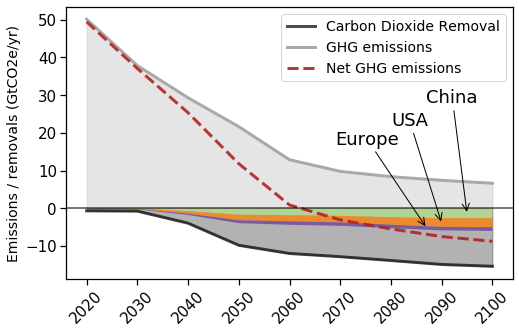

In [61]:
scen = ['SSP1-19-SPA1-V17']
single_reg=main_remind[(main_remind.Scenario.isin(scen)) &
                        (main_remind.Region == 'World')].copy()
single_reg.loc[:,'TOTAL_CDR'] = single_reg.loc[:,'TOTAL_CDR']*-10**-3
single_reg.loc[:,'Total_GHG'] = single_reg.loc[:,'Total_GHG']*10**-3
single_reg.loc[:,'CO2_Emissions'] = single_reg.loc[:,'CO2_Emissions']*10**-3

single_USA = main_remind[(main_remind.Scenario.isin(scen)) &
                        (main_remind.Region == 'USA')].copy()
single_USA.loc[:,'TOTAL_CDR'] = single_USA.loc[:,'TOTAL_CDR']*-10**-3 

single_CHN = main_remind[(main_remind.Scenario.isin(scen)) &
                        (main_remind.Region == 'CHN')].copy()
single_CHN.loc[:,'TOTAL_CDR'] = single_CHN.loc[:,'TOTAL_CDR']*-10**-3

single_EUR = main_remind[(main_remind.Scenario.isin(scen)) &
                        (main_remind.Region == 'EUR')].copy()
single_EUR.loc[:,'TOTAL_CDR'] = single_EUR.loc[:,'TOTAL_CDR']*-10**-3
#single_CHN.loc[:,'TOTAL_CDR'] = single_CHN.loc[:,'TOTAL_CDR'] - single_USA.loc[:,'TOTAL_CDR']


#rfilt = (mdf_remind.Country == 'World')
#mdf_remind_world = mdf_remind.loc[(mdf_remind.Year >= '1990') & rfilt].copy()
#mdf_remind_world.loc[:,'Value'] = mdf_remind_world.loc[:,'Value']*10**-3

# sns.lineplot(x = 'Year', y = 'Value', data = mdf_remind_world)

colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[10],colours[1],colours[7],colours[4],colours[5], colours[9]]


x = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

f,ax=plt.subplots(figsize=(8,5))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5})

sns.lineplot(x='Year',y='TOTAL_CDR',data=single_reg, linewidth = 3, label = 'Carbon Dioxide Removal', color = 'black', alpha = 0.7)
sns.lineplot(x='Year', y='CO2_Emissions',data = single_reg, linewidth = 3, label = 'GHG emissions', color = 'darkgrey')
sns.lineplot(x='Year',y='Total_GHG',data=single_reg, linewidth = 3, color = 'firebrick', label = 'Net GHG emissions', alpha = 0.9, dashes = True)
ax.lines[2].set_linestyle("--")                                          #'darkred' colours[5]
plt.stackplot(x, single_reg["TOTAL_CDR"], alpha =0.3, color = 'black') 
plt.stackplot(x, single_reg['CO2_Emissions'], alpha = 0.3, color = 'darkgrey')
plt.stackplot(x, single_CHN["TOTAL_CDR"],single_USA["TOTAL_CDR"], single_EUR["TOTAL_CDR"],colors = [colours[2], colours[7], colours[9]], alpha = 0.75) #alpha = 0.5
plt.annotate("China", xy=(2095, -1.5), xytext=(2087, 28), arrowprops=dict(arrowstyle="->"))
plt.annotate("USA", xy=(2090, -4), xytext=(2080, 22), arrowprops=dict(arrowstyle="->"))
plt.annotate("Europe", xy=(2087, -5.2), xytext=(2069, 17), arrowprops=dict(arrowstyle="->"))

# plt.line(x = np.arange(2020,2100,10), y = 0)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
plt.ylabel('Emissions / removals (GtCO2e/yr)', fontsize = 14)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 45)
plt.xlabel("", fontsize = 14)

plt.legend(loc = 'upper right', bbox_to_anchor=(1,1),ncol=1, fontsize = 14)
# plt.legend(loc='upper right', fontsize = 14)


plt.savefig(plot_path + 'N - Concept.Fig - Emissions_CDR.png', bbox_inches= 'tight', dpi = 300)
plt.savefig(plot_path + 'N - Concept.Fig - Emissions_CDR.svg', dpi = 300, transparent = True, bbox_inches= 'tight')